# Librairies

In [ ]:
!pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 462 kB 36.0 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


In [ ]:
!pip install xplique

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 19.7 MB/s 


In [ ]:
!pip install scipy==1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 5.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 4.1.4 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.1.0 which is incompatible.
jaxlib 0.3.15+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
jax 0.3.17 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
aeppl 0.0.33 requires scipy>=1.4.0, but you have scipy 1.1.0 which is incompatible.


In [ ]:
# Run encore si ça ce marche pas (tensorflow ne fonctionne pas du premier coup je ne sais pas pourquoi)
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os, random, shutil, time
import sklearn
import tensorflow as tf
import cv2
import h5py


from skimage import io
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,InputLayer
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc ,confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from skimage import io
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from PIL import Image, ImageOps

# MPL
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# CNN

# InceptionV3
from tensorflow.keras.applications import InceptionV3

# VGG16
from keras.applications.vgg16 import VGG16

## Attention network
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model

tf.compat.v1.disable_eager_execution()


In [ ]:
# Hashing
import hashlib
#from scipy.misc import imread, imresize, imshow
import matplotlib.pyplot as plt
%matplotlib inline
import time
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sns.set_palette("flare") #("husl")

# Preprocessing

## Create clean dataframe

In [ ]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

In [ ]:
# Sort paths for viral vs. bacteria pneumonia images
directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/'
dataset_folders = ['test','train', 'val']
dir_labels = ['PNEUMONIA', 'NORMAL']

path = []

img_size = 224 # input size for VGG16, also good for InceptionV3

def get_training_data(data_dir) :
  data = []
  duplicates = []
  hash_keys = dict()

  for folder in dataset_folders:
    # Path for each file
      dir = os.path.join(directory,folder)
      for label in dir_labels:
        dir_label = os.path.join(dir, label)
        for img in os.listdir(dir_label):
            try:
                img_arr = cv2.imread(os.path.join(dir_label, img), cv2.IMREAD_GRAYSCALE) # Gray images
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Resize to 224, 224
                
                # For MLP
                #image_eq = cv2.equalizeHist(resized_arr)

                # For CNN
                backtorgb = cv2.cvtColor(resized_arr,cv2.COLOR_GRAY2RGB) # Convert to RGB
                r_image, g_image, b_image = cv2.split(backtorgb) # Split into 3 channels --> RGB
                r_image_eq = cv2.equalizeHist(r_image) # Equalize histogram to enhance contrast
                g_image_eq = cv2.equalizeHist(g_image)
                b_image_eq = cv2.equalizeHist(b_image)
                image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq)) # Merge 3 channels RGB

                # Hashing for each image to detect any duplicate
                with open(os.path.join(dir_label, img), 'rb') as f:
                      filehash = hashlib.md5(f.read()).hexdigest()

                if label == 'PNEUMONIA':
                    if 'virus' in img:
                        data.append([image_eq, filehash, 'Viral'])
                    if 'bacteria' in img:
                        data.append([image_eq, filehash, 'Bacterial'])
            except Exception as e:
                print(e)
  return np.array(data)    


In [ ]:
all_data = get_training_data('../content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray')

In [ ]:
all_data

array([[array([[[ 18,  18,  18],
                [ 18,  18,  18],
                [ 18,  18,  18],
                ...,
                [133, 133, 133],
                [ 20,  20,  20],
                [132, 132, 132]],

               [[ 18,  18,  18],
                [ 17,  17,  17],
                [ 19,  19,  19],
                ...,
                [108, 108, 108],
                [142, 142, 142],
                [145, 145, 145]],

               [[ 17,  17,  17],
                [ 17,  17,  17],
                [ 18,  18,  18],
                ...,
                [100, 100, 100],
                [131, 131, 131],
                [148, 148, 148]],

               ...,

               [[  0,   0,   0],
                [  0,   0,   0],
                [  0,   0,   0],
                ...,
                [  0,   0,   0],
                [  0,   0,   0],
                [  0,   0,   0]],

               [[  0,   0,   0],
                [  0,   0,   0],
                [  0,   0,   

In [ ]:
raw_df = pd.DataFrame(all_data, columns = ['Image', 'Hash', 'Class'])

In [ ]:
print(raw_df)

                                                  Image  \
0     [[[18, 18, 18], [18, 18, 18], [18, 18, 18], [1...   
1     [[[252, 252, 252], [249, 249, 249], [222, 222,...   
2     [[[41, 41, 41], [42, 42, 42], [44, 44, 44], [4...   
3     [[[0, 0, 0], [0, 0, 0], [5, 5, 5], [8, 8, 8], ...   
4     [[[204, 204, 204], [202, 202, 202], [60, 60, 6...   
...                                                 ...   
4268  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [9, 9, 9], ...   
4269  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4270  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [19, 19, 19...   
4271  [[[23, 23, 23], [24, 24, 24], [24, 24, 24], [2...   
4272  [[[15, 15, 15], [16, 16, 16], [17, 17, 17], [1...   

                                  Hash      Class  
0     d529cabe7f79660a1c2028854491e4e2      Viral  
1     6da1d692a1a39ee18b644fc6633fc4de  Bacterial  
2     608d7ed2c16700a49d4253841cf63fbd  Bacterial  
3     520390708b8feb0f495ca8cd3ca09fd8  Bacterial  
4     243a49550bff1c19477f70cac

In [ ]:
raw_df.dtypes

Image    object
Hash     object
Class    object
dtype: object

Je regarde les images doublons en comparant les images de tous les dossiers confondus entre elles, grâce à la technique du "hashing".

Le "hashing" d'image est le processus d'utilisation d'un algorithme pour attribuer une valeur "hash" unique à une image. Les copies en double de l'image ont toutes exactement la même valeur "hash". Pour cette raison, on parle parfois "d'empreinte numérique"

In [ ]:
raw_df.duplicated(subset=['Hash'])

0       False
1       False
2       False
3       False
4       False
        ...  
4268    False
4269    False
4270    False
4271    False
4272    False
Length: 4273, dtype: bool

In [ ]:
print('Number of duplicated images:', raw_df.duplicated(subset=['Hash']).sum())

Number of duplicated images: 28


In [ ]:
df = raw_df.drop_duplicates(subset=['Hash'])

In [ ]:
len(raw_df)

4273

In [ ]:
len(df)

4245

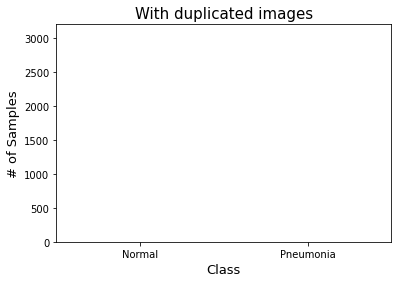

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Class', data=raw_df, order = ['Normal', 'Pneumonia'])
plt.xlabel("Class", fontsize= 13)
plt.ylabel("# of Samples", fontsize= 13)
plt.title("With duplicated images", fontsize=15)
plt.ylim(0,3200)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+50), fontsize = 13)
    
plt.show()

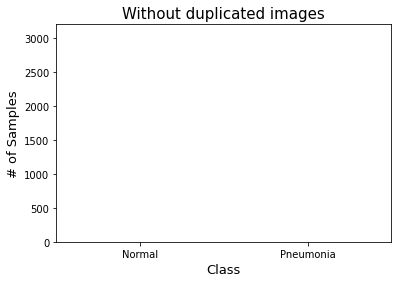

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Class', data=df, order = ['Normal', 'Pneumonia'] )
plt.xlabel("Class", fontsize= 13)
plt.ylabel("# of Samples", fontsize= 13)
plt.title("Without duplicated images", fontsize=15)

plt.ylim(0,3200)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+50), fontsize = 13)
    
plt.show()

Le nombre d'échantillons n'est pas équilibré entre nos 3 classes. Comme nous avons un grand nombre d'observations avec la plus petite classe avec ** observations, je décide de sous-échantillonner les autres classes majoritaires.

In [ ]:
df = df.drop('Hash', axis=1)

In [ ]:
df

,Image,Class
0,"[[[18, 18, 18], [18, 18, 18], [18, 18, 18], [1...",Viral
1,"[[[252, 252, 252], [249, 249, 249], [222, 222,...",Bacterial
2,"[[[41, 41, 41], [42, 42, 42], [44, 44, 44], [4...",Bacterial
3,"[[[0, 0, 0], [0, 0, 0], [5, 5, 5], [8, 8, 8], ...",Bacterial
4,"[[[204, 204, 204], [202, 202, 202], [60, 60, 6...",Bacterial
...,...,...
4268,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [9, 9, 9], ...",Bacterial
4269,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Bacterial
4270,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [19, 19, 19...",Bacterial
4271,"[[[23, 23, 23], [24, 24, 24], [24, 24, 24], [2...",Bacterial


In [ ]:
# Downsample
class_2,class_1 = df['Class'] .value_counts()
cn = df[df['Class'] == 'Bacterial']
cb = df[df['Class'] == 'Viral']
df_2 = cb.sample(class_1)
undersampled_df = pd.concat([df_2,cn],axis=0)

In [ ]:
undersampled_df['Class'].value_counts()

Bacterial    2760
Viral        1485
Name: Class, dtype: int64

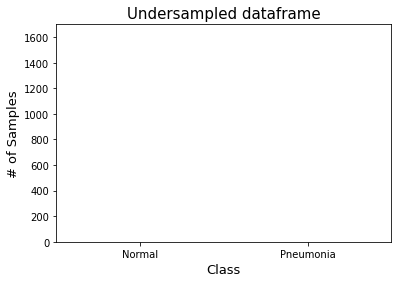

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Class', data=undersampled_df, order = ['Normal', 'Pneumonia'] )
plt.xlabel("Class", fontsize= 13)
plt.ylabel("# of Samples", fontsize= 13)
plt.title("Undersampled dataframe", fontsize=15)
plt.ylim(0,1700)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+50), fontsize = 13)
    
plt.show()

In [ ]:
numpy_df = undersampled_df.to_numpy()

In [ ]:
# Je détermine le x et y 
x = []
y = []
for feature, label in numpy_df:
    x.append(feature)
    y.append(label)


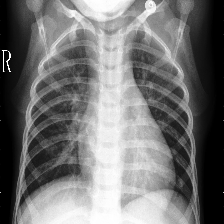

In [ ]:
# Je visualise une image pour m'assurer de la qualité
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
for i in range(1):
    fig = px.imshow(x[i], color_continuous_scale='gray', title=y[i])
    fig.show()

## Preprocessing

### Parameters

In [ ]:
nb_classes = 2 # Pour Normal, Viral, Bacterial
img_size = 224
nb_channels = 3

### Split dataset

In [ ]:
# Je sépare les données en 3 sets : train, validation et test 
  # Stratify permet d'équilibrer nos classes entre les sets 

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=42, stratify = y_train)



In [ ]:
# Je normalise les données et vérifie leurs dimensions
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f'X_train shape: {x_train.shape}')
print(f'X_val shape: {x_val.shape}')
print(f'X_test shape: {x_test.shape}')
print(f'----------------------------------')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'----------------------------------')
print(f'Number of training examples:  {len(x_train)}')
print(f'Number of validation examples: {len(x_val)}')
print(f'Number of testing examples:  {len(x_test)}')

X_train shape: (3056, 224, 224, 3)
X_val shape: (340, 224, 224, 3)
X_test shape: (849, 224, 224, 3)
----------------------------------
y_train shape: (3056,)
y_val shape: (340,)
y_test shape: (849,)
----------------------------------
Number of training examples:  3056
Number of validation examples: 340
Number of testing examples:  849


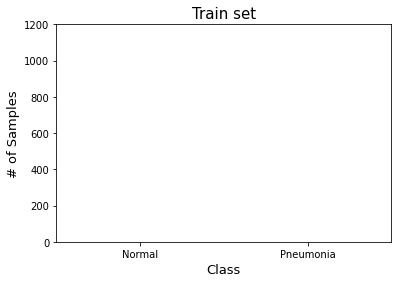

In [ ]:
# Train set
plt.figure(figsize=(6,4))
ax = sns.countplot(x=y_train,  order = ['Normal', 'Pneumonia'])
plt.xlabel("Class", fontsize= 13)
plt.ylabel("# of Samples", fontsize= 13)
plt.title("Train set", fontsize= 15)
plt.ylim(0,1200)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+50), fontsize = 13)
    
plt.show()

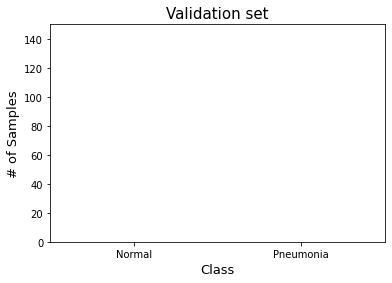

In [ ]:
# Validation set
plt.figure(figsize=(6,4))
ax = sns.countplot(x=y_val,  order = ['Normal', 'Pneumonia'] )
plt.xlabel("Class", fontsize= 13)
plt.ylabel("# of Samples", fontsize= 13)
plt.title("Validation set", fontsize= 15)
plt.ylim(0,150)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+10), fontsize = 13)
    
plt.show()

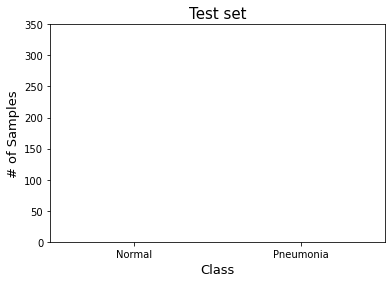

In [ ]:
# Test set
plt.figure(figsize=(6,4))
ax = sns.countplot(x=y_test, order = ['Normal', 'Pneumonia'])
plt.xlabel("Class", fontsize= 13)
plt.ylabel("# of Samples", fontsize= 13)
plt.title("Test set", fontsize= 15)
plt.ylim(0,350)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+10), fontsize = 13)
    
plt.show()

### OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#Reshaping the dataset by adding a new axis
y_train = y_train[:,np.newaxis]
y_val = y_val[:,np.newaxis]
y_test = y_test[:,np.newaxis]

#Initialize onehot encoder
encode = OneHotEncoder(sparse=False)


#Encoding the images
y_train_encode = encode.fit_transform(y_train)
y_val_encode = encode.fit_transform(y_val)
y_test_encode = encode.transform(y_test)

#printing the shapes of the vectors 
print('Y_train: ' + str(y_train_encode.shape))
print('Y_val: ' + str(y_val_encode.shape))
print('Y_test:  '  + str(y_test_encode.shape))
print(encode.categories_)
print(encode.get_feature_names())



Y_train: (3056, 2)
Y_val: (340, 2)
Y_test:  (849, 2)
[array(['Bacterial', 'Viral'], dtype='<U9')]
['x0_Bacterial' 'x0_Viral']


In [ ]:
#y_train_encode = pd.DataFrame(y_train_encode)
#y_train_encode.columns = ['Bacterial', 'Normal', 'Viral']

#y_val_encode = pd.DataFrame(y_val_encode)
#y_val_encode.columns = ['Bacterial', 'Normal', 'Viral']

#y_test_encode = pd.DataFrame(y_test_encode)
#y_test_encode.columns = ['Bacterial', 'Normal', 'Viral']


### Callbacks

L'**EarlyStopping** est permet d'arrêter l'entraînement une fois que les performances du modèle cessent de s'améliorer sur un ensemble de données de validation.
**ReduceLROnPlateau** permet de réduire le taux d'apprentissage lorsqu'une métrique a cessé de s'améliorer.
**ModelCheckpoint** permet de définir où vérifier les poids du modèle, comment nommer le fichier et dans quelles circonstances créer un point de contrôle du modèle.

La **val_categorical_accuracy **calcule le pourcentage de précision de valeurs prédites (yPred) qui correspondent aux valeurs réelles (yTrue) pour les one-hot labels. Elle prend en compte le set de validation (et non de training) pour éviter l'overfitting

In [ ]:
#CallBacks Function
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
early_stop = EarlyStopping(monitor="val_loss",
                         patience=5,
                         mode="auto",)


epoch = 40 
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)



model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

callbacks=[early_stop, lr_sched, model_checkpoint]

### Clean variables

In [ ]:
del all_data
del raw_df
del df 
del undersampled_df
del y_train, y_val, y_test

## VGG16 Multiclasses

In [ ]:
# Implement VGG16 and add attention layers 

in_lay = Input(x_train.shape[1:])
base_pretrained_model = VGG16(input_shape =  x_train.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w]) #linear
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(nb_classes, activation = 'sigmoid')(dr_steps) 
attention_vgg16 = Model(inputs = [in_lay], outputs = [out_layer])

# Define parameters
attention_vgg16.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
attention_vgg16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 512)   2048        ['vgg16[1][0]']                  
 alization)                                                                                       
                                                                                              

In [ ]:
attention_vgg16_history = attention_vgg16.fit(x_train, y_train_encode, 
                                  validation_data = (x_val, y_val_encode), 
                                  epochs = 100, 
                                  callbacks = callbacks)

Train on 3056 samples, validate on 340 samples
Epoch 1/100
3056/3056 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.6764
Epoch 1: val_loss improved from inf to 0.59171, saving model to best_model.h5
3056/3056 [==============================] - 40s 13ms/sample - loss: 0.6140 - accuracy: 0.6764 - val_loss: 0.5917 - val_accuracy: 0.6632 - lr: 1.0000e-04
Epoch 2/100
3056/3056 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7495
Epoch 2: val_loss improved from 0.59171 to 0.55619, saving model to best_model.h5
3056/3056 [==============================] - 15s 5ms/sample - loss: 0.5367 - accuracy: 0.7495 - val_loss: 0.5562 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 3/100
3056/3056 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.7497
Epoch 3: val_loss improved from 0.55619 to 0.52705, saving model to best_model.h5
3056/3056 [==============================] - 15s 5ms/sample - loss: 0.5198 - accuracy: 0.7497 - val_loss: 0

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
attention_vgg16.save('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model/attention_vgg16.h5') 
base_pretrained_model.save('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model/vgg16_pretrained.h5')

In [ ]:
# load the best version of the model
#bone_age_model.load_weights(weight_path)

### Performance du modèle

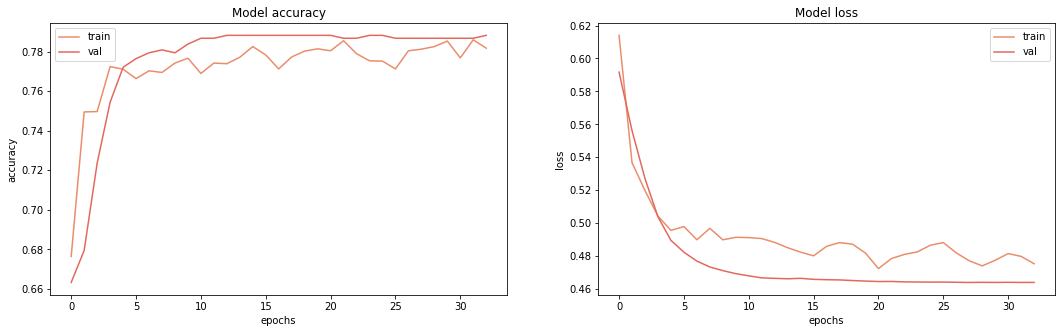

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(attention_vgg16_history.history[element])
    axis[i].plot(attention_vgg16_history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [ ]:
#attention_vgg16 = load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/models/attention_vgg16.h5') 

In [ ]:
pred = attention_vgg16.predict(x_train)
pred = np.argmax(pred, axis=1)
y_train_argmax = np.argmax(y_train_encode, axis=1)

Train Result:
Accuracy Score: 80.24%
_______________________________________________
CLASSIFICATION REPORT:
                Normal    Pneumonia  accuracy    macro avg  weighted avg
precision     0.815034     0.770035  0.802356     0.792535      0.799293
recall        0.900352     0.620206  0.802356     0.760279      0.802356
f1-score      0.855571     0.687047  0.802356     0.771309      0.796621
support    1987.000000  1069.000000  0.802356  3056.000000   3056.000000
_______________________________________________
Confusion Matrix: 
 [[1789  198]
 [ 406  663]]

Test Result:
Accuracy Score: 76.21%
_______________________________________________
CLASSIFICATION REPORT:
               Normal   Pneumonia  accuracy   macro avg  weighted avg
precision    0.788779    0.695473  0.762073    0.742126      0.756138
recall       0.865942    0.569024  0.762073    0.717483      0.762073
f1-score     0.825561    0.625926  0.762073    0.725744      0.755724
support    552.000000  297.000000  0.762073 

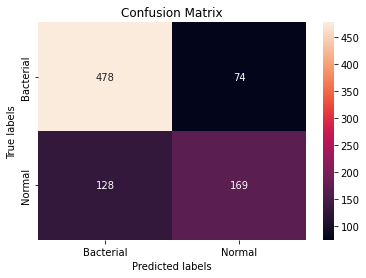

In [ ]:
def print_score(attention_vgg16, x_train, y_train_encode, x_test, y_test_encode, train=True):
    if train:
        pred = attention_vgg16.predict(x_train)
        pred = np.argmax(pred, axis=1)
        y_train_argmax = np.argmax(y_train_encode, axis=1)
        clf_report = pd.DataFrame(classification_report(y_train_argmax, pred, output_dict=True, target_names = ['Normal', 'Pneumonia']))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train_argmax, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train_argmax, pred)}\n")
        
    elif train==False:
        pred = attention_vgg16.predict(x_test)
        pred = np.argmax(pred, axis=1)
        y_test_argmax = np.argmax(y_test_encode, axis=1)
        cm = confusion_matrix(y_test_argmax, pred)
        clf_report = pd.DataFrame(classification_report(y_test_argmax, pred, output_dict=True, target_names = ['Normal', 'Pneumonia']))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test_argmax, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['Bacterial','Normal', 'Viral']); ax.yaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])

print_score(attention_vgg16, x_train, y_train_encode, x_test, y_test_encode, train=True)
print_score(attention_vgg16, x_train,y_train_encode, x_test, y_test_encode, train=False)

In [ ]:
pred = attention_vgg16.predict(x_val)
pred = np.argmax(pred, axis=1)
y_val_argmax = np.argmax(y_val_encode, axis=1)
clf_report = pd.DataFrame(classification_report(y_val_argmax, pred, output_dict=True, target_names = ['Bacterial','Normal', 'Viral']))
print("Validation Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_val_argmax, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_val_argmax, pred)}\n")

ValueError: ignored

### Courbe ROC

In [ ]:
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
y_pred = attention_vgg16.predict(x_test)
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encode[:, i], y_pred[:, i], )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_encode.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_auc_scores = []
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='darkorange', linestyle=':', linewidth=1)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='mediumseagreen', linestyle=':', linewidth=1)

plt.plot(fpr[1], tpr[1], color='hotpink', lw=2,label='ROC curve of class Normal (AUC = {1:0.2f})'''.format(1, roc_auc[1]))
roc_auc_scores.append(roc_auc[1])

plt.plot(fpr[0], tpr[0], color='mediumpurple', lw=2,label='ROC curve of class Bacterial (AUC = {1:0.2f})'''.format(0, roc_auc[0]))
roc_auc_scores.append(roc_auc[0])

plt.plot(fpr[2], tpr[2], color='lightskyblue', lw=2,label='ROC curve of class Viral (AUC = {1:0.2f})'''.format(2, roc_auc[2]))
roc_auc_scores.append(roc_auc[2])

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extending the ROC Curve to Multi-Class')
plt.legend(loc="lower right")
plt.show()

# class 0 = Bacterial
# class 1 = Normal
# class 2 = Viral

### Heat map

In [ ]:
predict_prob=attention_vgg16.predict(x_test)
predict_classes=np.argmax(predict_prob,axis=1)
y_test_argmax=np.argmax(y_test_encode,axis=1)

# get the attention layer since it is the only one with a single output dim
for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(x_test)), size = 10)
attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = x_test[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_class = y_test_argmax[c_idx]
    img_ax.set_title('Chest X-Ray\nClass {}' .format(real_class))
    pred_class = np.argmax(attention_vgg16.predict(cur_img),axis=1)
    attn_ax.set_title('Attention Map\nPred {}' .format(pred_class))
fig.savefig('attention_map.png', dpi = 300)

# Importation modèles et fonctioncs

In [ ]:
img_size = 224

In [ ]:
def print_pred_multi(model, patient):
  pred = model.predict(patient)
  class_pred = np.argmax(pred, axis=1)

  print("Probabilités :")
  print("  Bacterial.   Normal.    Viral. ")
  print(pred)
  print("------------------------------------- ")
  print("Prédiction de la classe :")
  if class_pred == 0:
    print("Bacterial")
  elif class_pred == 1:
    print("Normal")
  else:
    print("Viral")

def print_pred_binaire(model, patient):
  pred = model.predict(patient)
  class_pred = np.argmax(pred, axis=1)

  print("Probabilités :")
  print("  Normal.         Pneumonie. ")
  print(pred)
  print("------------------------------------- ")
  print("Prédiction de la classe :")
  if class_pred == 0:
    print("Normal")
  else:
    print("Pneumonie")


def print_pred_binaire_pneu(model, patient):
  pred = model.predict(patient)
  class_pred = np.argmax(pred, axis=1)

  print("Probabilités :")
  print("  Bactérienne.     Virale. ")
  print(pred)
  print("------------------------------------- ")
  print("Prédiction de la classe :")
  if class_pred == 0:
    print("Bactérienne")
  else:
    print("Virale")

In [ ]:
# Modèles multi-classes
mlp = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model/mlp.h5') 
cnn = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model/cnn.h5') 
inceptionv3 = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model/inception.h5') 
vgg16 = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model/attention_vgg16.h5') 

# Modèles binaires Normal vs. Pneumonie
mlp_b = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary/mlp.h5') 
cnn_b = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary/cnn.h5') 
inceptionv3_b = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary/inception.h5') 
vgg16_b = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary/attention_vgg16.h5') 

# Modèles binaires Pneumonie Bactérienne vs. Virale
mlp_bp = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary_pneu/mlp.h5') 
cnn_bp = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary_pneu/cnn.h5') 
inceptionv3_bp = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary_pneu/inception.h5') 
vgg16_bp = keras.models.load_model('/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/final_model_binary_pneu/attention_vgg16.h5') 

Instructions for updating:
Colocations handled automatically by placer.


# 1er patient - Pneumonie Virale


### Données

In [ ]:
### Shape pour MLP

directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/test/PNEUMONIA/person19_virus_50.jpeg'
img_arr = cv2.imread(directory, cv2.IMREAD_GRAYSCALE) 
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodeler à la taille souhaitée
patient_viral = cv2.equalizeHist(resized_arr)
patient_viral = patient_viral.reshape(-1, img_size*img_size).astype('float32')
print('patient_viral float32 shape:', patient_viral.shape)


patient_viral float32 shape: (1, 50176)


In [ ]:
### Shape pour CNN

directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/test/PNEUMONIA/person19_virus_50.jpeg'
img_arr = cv2.imread(directory, cv2.IMREAD_GRAYSCALE) 
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodeler à la taille souhaitée
backtorgb = cv2.cvtColor(resized_arr,cv2.COLOR_GRAY2RGB) # Conversion en RGB
r_image, g_image, b_image = cv2.split(backtorgb) # Séparation des 3 canaux RGB
r_image_eq = cv2.equalizeHist(r_image) # égalisation d'histogramme pour augmenter le contraste
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
patient_viral = cv2.merge((r_image_eq, g_image_eq, b_image_eq)) # Assemblage des 3 canaux RGB


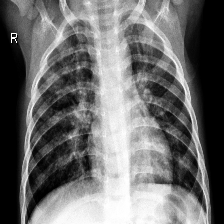

In [ ]:
# Je visualise une image pour m'assurer de la qualité
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
fig = px.imshow(patient_viral, color_continuous_scale='gray', title="Patient Pneumonie Virale")
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:
patient_viral = np.array(patient_viral) / 255
print(f'patient_viral shape: {patient_viral.shape}')
patient_viral = patient_viral.reshape(-1,img_size,img_size,3)
print(f'patient_viral shape: {patient_viral.shape}')

patient_viral shape: (224, 224, 3)
patient_viral shape: (1, 224, 224, 3)


### Modèles Multiclasses

In [ ]:
# MLP
print("Prédiction MLP Multiclasses")
print("------------------------------------- ")
print_pred_multi(mlp, patient_viral)

Prédiction MLP Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0. 0. 1.]]
------------------------------------- 
Prédiction de la classe :
Viral


In [ ]:
# CNN
print("Prédiction CNN Multiclasses")
print("------------------------------------- ")
print_pred_multi(cnn, patient_viral)

Prédiction CNN Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0.01193608 0.02164934 0.9664146 ]]
------------------------------------- 
Prédiction de la classe :
Viral


In [ ]:
# InceptionV3
print("Prédiction InceptionV3 Multiclasses")
print("------------------------------------- ")
print_pred_multi(inceptionv3, patient_viral)

Prédiction InceptionV3 Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0.0620758  0.03509411 0.9028301 ]]
------------------------------------- 
Prédiction de la classe :
Viral


In [ ]:
# VGG16
print("Prédiction InceptionV3 Multiclasses")
print("------------------------------------- ")
print_pred_multi(attention_vgg16, patient_viral)

Prédiction InceptionV3 Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0.09396699 0.05821062 0.84782237]]
------------------------------------- 
Prédiction de la classe :
Viral


In [ ]:
# Je récupère la couche d'attention du modèle VGG16

for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

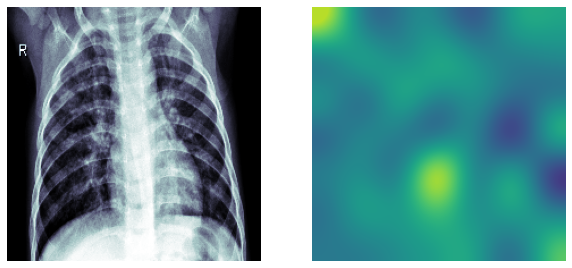

In [ ]:
# Je visualise la heat map du modèle d'attention VGG16

fig, ax = plt.subplots(1, 2, figsize = (10, 10))

attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)])

attn_img = attn_func([patient_viral, 0])[0]
ax[0].imshow(patient_viral[0,:,:,0], cmap = 'bone')
ax[0].axis('off')
ax[1].imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
ax[1].axis('off')


fig.savefig('attention_map.png', dpi = 300)

### Modèles binaires

In [ ]:
# MLP
print("Prédiction MLP Binaire")
print("------------------------------------- ")
print_pred_binaire(mlp_b, patient_viral)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(mlp_bp, patient_viral)

Prédiction MLP Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0. 1.]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0. 1.]]
------------------------------------- 
Prédiction de la classe :
Virale


In [ ]:
# CNN
print("Prédiction CNN Binaire")
print("------------------------------------- ")
print_pred_binaire(cnn_b, patient_viral)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(cnn_bp, patient_viral)

Prédiction CNN Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0.9932612  0.00646693]]
------------------------------------- 
Prédiction de la classe :
Normal
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0.00649002 0.99212795]]
------------------------------------- 
Prédiction de la classe :
Virale


In [ ]:
# InceptionV3
print("Prédiction InceptionV3 Binaire")
print("------------------------------------- ")
print_pred_binaire(inceptionv3_b, patient_viral)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(inceptionv3_bp, patient_viral)

Prédiction InceptionV3 Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0.09720522 0.8732074 ]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0.467204  0.6254848]]
------------------------------------- 
Prédiction de la classe :
Virale


In [ ]:
# VGG16
print("Prédiction VGG16 Binaire")
print("------------------------------------- ")
print_pred_binaire(vgg16_b, patient_viral)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(vgg16_bp, patient_viral)

Prédiction VGG16 Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0.09908009 0.89943814]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0.12409909 0.8754345 ]]
------------------------------------- 
Prédiction de la classe :
Virale


In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

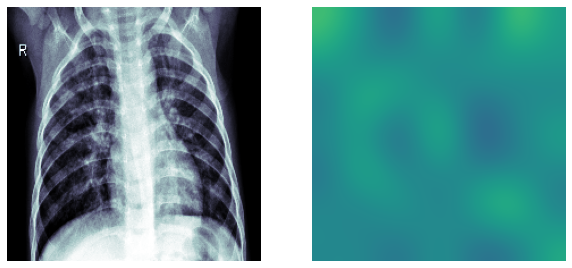

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))

attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)])
attn_img = attn_func([patient_viral, 0])[0]
ax[0].imshow(patient_viral[0,:,:,0], cmap = 'bone')
ax[0].axis('off')
ax[1].imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
ax[1].axis('off')


fig.savefig('attention_map.png', dpi = 300)

# 2eme Patient - Pneumonie Bactérienne

### Données

In [ ]:
### Shape pour MLP

directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/test/PNEUMONIA/person147_bacteria_705.jpeg'
img_arr = cv2.imread(directory, cv2.IMREAD_GRAYSCALE) 
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodeler à la taille souhaitée
patient_bacterial = cv2.equalizeHist(resized_arr)
patient_bacterial = patient_bacterial.reshape(-1, img_size*img_size).astype('float32')
print('patient_bacterial float32 shape:', patient_bacterial.shape)

patient_bacterial float32 shape: (1, 50176)


In [ ]:
### Shape pour CNN

directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/test/PNEUMONIA/person147_bacteria_705.jpeg'
img_arr = cv2.imread(directory, cv2.IMREAD_GRAYSCALE) 
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodeler à la taille souhaitée
backtorgb = cv2.cvtColor(resized_arr,cv2.COLOR_GRAY2RGB) # Conversion en RGB
r_image, g_image, b_image = cv2.split(backtorgb) # Séparation des 3 canaux RGB
r_image_eq = cv2.equalizeHist(r_image) # égalisation d'histogramme pour augmenter le contraste
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
patient_bacterial = cv2.merge((r_image_eq, g_image_eq, b_image_eq)) # Assemblage des 3 canaux RGB


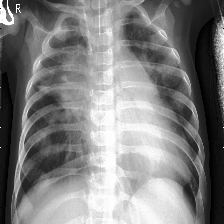

In [ ]:
# Je visualise une image pour m'assurer de la qualité
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
fig = px.imshow(patient_bacterial, color_continuous_scale='gray', title="Patient Pneumonie Bactérienne")
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:
patient_bacterial = np.array(patient_bacterial) / 255
print(f'patient_bacterial shape: {patient_bacterial.shape}')
patient_bacterial = patient_bacterial.reshape(-1,img_size,img_size,3)
print(f'patient_bacterial shape: {patient_bacterial.shape}')

patient_bacterial shape: (224, 224, 3)
patient_bacterial shape: (1, 224, 224, 3)


### Modèles multiclasses

In [ ]:
# MLP
print("Prédiction MLP Multiclasses")
print("------------------------------------- ")
print_pred_multi(mlp, patient_bacterial)

Prédiction MLP Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[1. 0. 0.]]
------------------------------------- 
Prédiction de la classe :
Bacterial


In [ ]:
# CNN
print("Prédiction CNN Multiclasses")
print("------------------------------------- ")
print_pred_multi(cnn, patient_bacterial)

Prédiction CNN Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[9.93564665e-01 1.00490526e-10 6.43525971e-03]]
------------------------------------- 
Prédiction de la classe :
Bacterial


In [ ]:
# InceptionV3
print("Prédiction InceptionV3 Multiclasses")
print("------------------------------------- ")
print_pred_multi(inceptionv3, patient_bacterial)

Prédiction InceptionV3 Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[8.87824476e-01 5.48957265e-04 1.11626565e-01]]
------------------------------------- 
Prédiction de la classe :
Bacterial


In [ ]:
# VGG16
print("Prédiction InceptionV3 Multiclasses")
print("------------------------------------- ")
print_pred_multi(attention_vgg16, patient_bacterial)

Prédiction InceptionV3 Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0.8515157  0.001024   0.14746031]]
------------------------------------- 
Prédiction de la classe :
Bacterial


In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

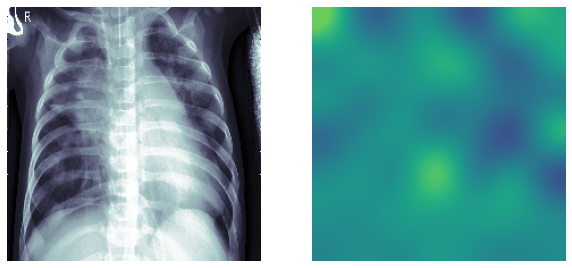

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))
attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)])
attn_img = attn_func([patient_bacterial, 0])[0]
ax[0].imshow(patient_bacterial[0,:,:,0], cmap = 'bone')
ax[0].axis('off')
ax[1].imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
ax[1].axis('off')


fig.savefig('attention_map.png', dpi = 300)


### Modèles binaires 

In [ ]:
# MLP
print("Prédiction MLP Binaire")
print("------------------------------------- ")
print_pred_binaire(mlp_b, patient_bacterial)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(mlp_bp, patient_bacterial)

Prédiction MLP Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0. 1.]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[1. 0.]]
------------------------------------- 
Prédiction de la classe :
Bactérienne


In [ ]:
# CNN
print("Prédiction CNN Binaire")
print("------------------------------------- ")
print_pred_binaire(cnn_b, patient_bacterial)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(cnn_bp, patient_bacterial)

Prédiction CNN Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[2.3181335e-09 1.0000000e+00]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0.9756056  0.01021881]]
------------------------------------- 
Prédiction de la classe :
Bactérienne


In [ ]:
# InceptionV3
print("Prédiction InceptionV3 Binaire")
print("------------------------------------- ")
print_pred_binaire(inceptionv3_b, patient_bacterial)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(inceptionv3_bp, patient_bacterial)

Prédiction InceptionV3 Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[9.408323e-04 9.986755e-01]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0.87120825 0.13174944]]
------------------------------------- 
Prédiction de la classe :
Bactérienne


In [ ]:
# VGG16
print("Prédiction VGG16 Binaire")
print("------------------------------------- ")
print_pred_binaire(vgg16_b, patient_bacterial)
print("------------------------------------- ")
print("------------------------------------- ")
print_pred_binaire_pneu(vgg16_bp, patient_bacterial)

Prédiction VGG16 Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0.00429408 0.9959025 ]]
------------------------------------- 
Prédiction de la classe :
Pneumonie
------------------------------------- 
------------------------------------- 
Probabilités :
  Bactérienne.     Virale. 
[[0.87392986 0.1275977 ]]
------------------------------------- 
Prédiction de la classe :
Bactérienne


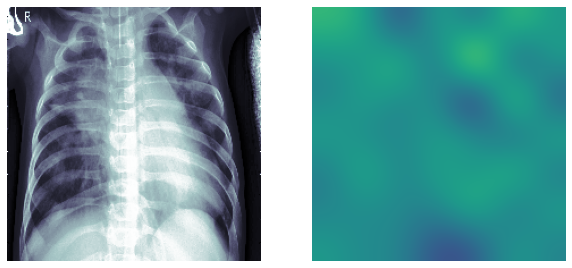

In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

fig, ax = plt.subplots(1, 2, figsize = (10, 10))

attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)])
attn_img = attn_func([patient_bacterial, 0])[0]

ax[0].imshow(patient_bacterial[0,:,:,0], cmap = 'bone')
ax[0].axis('off')
ax[1].imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
ax[1].axis('off')


fig.savefig('attention_map.png', dpi = 300)

# 3eme patient - Normal

### Données

In [ ]:
### Shape pour MLP

directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/test/NORMAL/IM-0029-0001.jpeg'
img_arr = cv2.imread(directory, cv2.IMREAD_GRAYSCALE) 
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodeler à la taille souhaitée
patient_normal = cv2.equalizeHist(resized_arr)
patient_normal = patient_normal.reshape(-1, img_size*img_size).astype('float32')
print('patient_normal float32 shape:', patient_normal.shape)

patient_normal float32 shape: (1, 50176)


In [ ]:
### Shape pour CNN

directory = '/content/gdrive/MyDrive/DESU_DS/Projet_final/chest_xray/test/NORMAL/IM-0029-0001.jpeg'
img_arr = cv2.imread(directory, cv2.IMREAD_GRAYSCALE) # Les images sont en Gray scale
resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodeler à la taille souhaitée
backtorgb = cv2.cvtColor(resized_arr,cv2.COLOR_GRAY2RGB) # Conversion en RGB
r_image, g_image, b_image = cv2.split(backtorgb) # Séparation des 3 canaux RGB
r_image_eq = cv2.equalizeHist(r_image) # égalisation d'histogramme pour augmenter le contraste
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
patient_normal = cv2.merge((r_image_eq, g_image_eq, b_image_eq)) # Assemblage des 3 canaux RGB


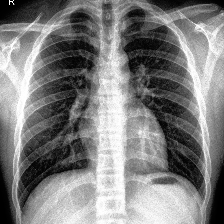

In [ ]:
# Je visualise une image pour m'assurer de la qualité
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
fig = px.imshow(patient_normal, color_continuous_scale='gray', title="Patient Normal")
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:
patient_normal = np.array(patient_normal) / 255
print(f'patient_normal shape: {patient_normal.shape}')
patient_normal = patient_normal.reshape(-1,img_size,img_size,3)
print(f'patient_normal shape: {patient_normal.shape}')

patient_normal shape: (224, 224, 3)
patient_normal shape: (1, 224, 224, 3)


### Modèles multiclasses

In [ ]:
# MLP
print("Prédiction MLP Multiclasses")
print("------------------------------------- ")
print_pred_multi(mlp, patient_normal)

Prédiction MLP Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0. 1. 0.]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# CNN
print("Prédiction CNN Multiclasses")
print("------------------------------------- ")
print_pred_multi(cnn, patient_normal)

Prédiction CNN Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[2.094204e-05 9.927208e-01 7.258274e-03]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# InceptionV3
print("Prédiction InceptionV3 Multiclasses")
print("------------------------------------- ")
print_pred_multi(inceptionv3, patient_normal)

Prédiction InceptionV3 Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0.05039614 0.42495084 0.524653  ]]
------------------------------------- 
Prédiction de la classe :
Viral


In [ ]:
# VGG16
print("Prédiction InceptionV3 Multiclasses")
print("------------------------------------- ")
print_pred_multi(attention_vgg16, patient_viral)

Prédiction InceptionV3 Multiclasses
------------------------------------- 
Probabilités :
  Bacterial.   Normal.    Viral. 
[[0.02091078 0.9204952  0.05859406]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

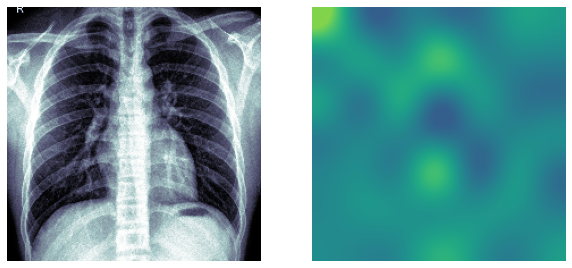

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))

attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
attn_img = attn_func([patient_normal, 0])[0]
ax[0].imshow(patient_normal[0,:,:,0], cmap = 'bone')
ax[0].axis('off')
ax[1].imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
ax[1].axis('off')


fig.savefig('attention_map.png', dpi = 300)

### Modèles binaires

In [ ]:
# MLP
print("Prédiction MLP Binaire")
print("------------------------------------- ")
print_pred_binaire(mlp_b, patient_normal)

Prédiction MLP Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[1. 0.]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# CNN
print("Prédiction CNN Binaire")
print("------------------------------------- ")
print_pred_binaire(cnn_b, patient_normal)


Prédiction CNN Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[9.9960083e-01 2.2995472e-04]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# InceptionV3
print("Prédiction InceptionV3 Binaire")
print("------------------------------------- ")
print_pred_binaire(inceptionv3_b, patient_normal)


Prédiction InceptionV3 Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0.67572975 0.33107316]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# VGG16
print("Prédiction VGG16 Binaire")
print("------------------------------------- ")
print_pred_binaire(attention_vgg16, patient_normal)


Prédiction VGG16 Binaire
------------------------------------- 
Probabilités :
  Normal.         Pneumonie. 
[[0.9932656 0.007541 ]]
------------------------------------- 
Prédiction de la classe :
Normal


In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attention_vgg16.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

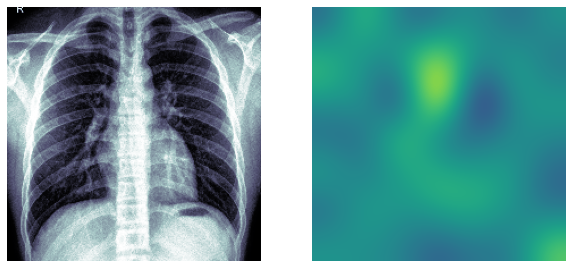

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))

attn_func = K.function(inputs = [base_pretrained_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
attn_img = attn_func([patient_normal, 0])[0]

ax[0].imshow(patient_normal[0,:,:,0], cmap = 'bone')
ax[0].axis('off')
ax[1].imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
ax[1].axis('off')


fig.savefig('attention_map.png', dpi = 300)